In [353]:
#imports pakages
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches


#import helpers
from sklearn.model_selection import train_test_split

#keras
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Conv1D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense, Input, UpSampling2D, concatenate
from keras.optimizers import SGD, RMSprop, Adam

from keras import backend as K

%matplotlib inline
%config IPCompleter.greedy=True


# Getting Started

In [388]:

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    #print(U)
    #print(V)
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    #print('Creating data:')
    for i in range(nb_samples):
        if i % 1000 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    #print('Creating data:')
    for i in range(nb_samples):
        if i % 500 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]



def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

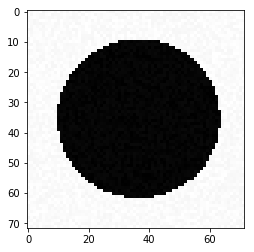

In [389]:
im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

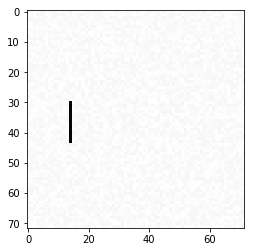

In [390]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

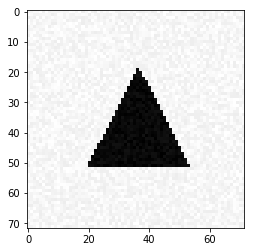

In [391]:
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

# Simple Classification

In [438]:
[X_train, Y_train] = generate_dataset_classification(300, 20)
[X_test, Y_test] = generate_dataset_classification(60, 20)
Y_train = np_utils.to_categorical(Y_train).reshape((-1,1,3))
Y_test = np_utils.to_categorical(Y_test).reshape((-1, 1, 3))
X_train = X_train.reshape((-1, 1, 5184))
X_test = X_test.reshape((-1,1,5184))

0
0


### Stochastic Gradient Descent

In [452]:
epochs = 100
batch_size = 32
nb_channels = 1

model = Sequential()
model.add(Dense(52,input_shape=(1, 5184)))
model.add(Activation("relu"))
model.add(Dense(3))
model.add(Activation("softmax"))

# Defining the first Optimization Method
sgd = SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_117 (Dense)            (None, 1, 52)             269620    
_________________________________________________________________
activation_204 (Activation)  (None, 1, 52)             0         
_________________________________________________________________
dense_118 (Dense)            (None, 1, 3)              159       
_________________________________________________________________
activation_205 (Activation)  (None, 1, 3)              0         
Total params: 269,779
Trainable params: 269,779
Non-trainable params: 0
_________________________________________________________________


In [453]:
history = model.fit(x= X_train, 
              y= Y_train,
              validation_split=0.3,
              batch_size=batch_size,
              epochs=epochs,
              shuffle=True)

Train on 210 samples, validate on 90 samples
Epoch 1/100
210/210 [==============================] - 2s 8ms/step - loss: 1.0518 - acc: 0.5238 - val_loss: 1.0935 - val_acc: 0.4889
Epoch 2/100
210/210 [==============================] - 0s 309us/step - loss: 0.9231 - acc: 0.5524 - val_loss: 0.9875 - val_acc: 0.5222
Epoch 3/100
210/210 [==============================] - 0s 309us/step - loss: 0.8201 - acc: 0.6857 - val_loss: 0.9730 - val_acc: 0.5556
Epoch 4/100
210/210 [==============================] - 0s 313us/step - loss: 0.7874 - acc: 0.7095 - val_loss: 0.8981 - val_acc: 0.5222
Epoch 5/100
210/210 [==============================] - 0s 337us/step - loss: 0.7494 - acc: 0.6952 - val_loss: 0.8084 - val_acc: 0.6111
Epoch 6/100
210/210 [==============================] - 0s 304us/step - loss: 0.7151 - acc: 0.7619 - val_loss: 0.9202 - val_acc: 0.5778
Epoch 7/100
210/210 [==============================] - 0s 337us/step - loss: 0.6903 - acc: 0.7524 - val_loss: 0.7773 - val_acc: 0.6444
Epoch 8/100


Epoch 61/100
210/210 [==============================] - 0s 275us/step - loss: 0.2933 - acc: 0.9190 - val_loss: 0.3908 - val_acc: 0.8667
Epoch 62/100
210/210 [==============================] - 0s 275us/step - loss: 0.2793 - acc: 0.9524 - val_loss: 0.3658 - val_acc: 0.9000
Epoch 63/100
210/210 [==============================] - 0s 299us/step - loss: 0.2755 - acc: 0.9524 - val_loss: 0.3649 - val_acc: 0.9667
Epoch 64/100
210/210 [==============================] - 0s 309us/step - loss: 0.2825 - acc: 0.9429 - val_loss: 0.3610 - val_acc: 0.9000
Epoch 65/100
210/210 [==============================] - 0s 313us/step - loss: 0.2685 - acc: 0.9619 - val_loss: 0.3811 - val_acc: 0.8556
Epoch 66/100
210/210 [==============================] - 0s 323us/step - loss: 0.2744 - acc: 0.9333 - val_loss: 0.3724 - val_acc: 0.8889
Epoch 67/100
210/210 [==============================] - 0s 323us/step - loss: 0.2788 - acc: 0.8952 - val_loss: 0.4180 - val_acc: 0.8222
Epoch 68/100
210/210 [==========================

In [454]:
model.evaluate(x=X_test, y = Y_test, batch_size = batch_size)

60/60 [==============================] - 0s 183us/step


[0.2621395101149877, 0.9333333214124043]

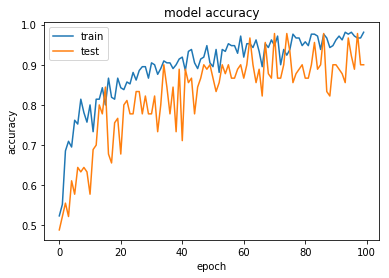

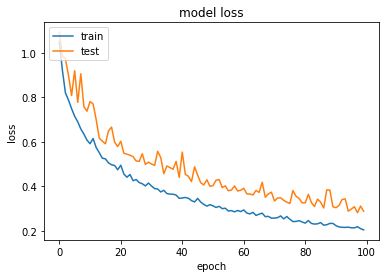

In [455]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Nous reconnaissons bien là une convergence habituelle pour l'algorithme de stochastic gradient descent.

### Adam Optimizer

In [459]:
epochs = 30
batch_size = 16
nb_channels = 1

adam_model = Sequential()
adam_model.add(Dense(52,input_shape=(1, 5184)))
adam_model.add(Activation("relu"))
adam_model.add(Dense(3))
adam_model.add(Activation("softmax"))

# Defining the first Optimization Method
adam_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
adam_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_121 (Dense)            (None, 1, 52)             269620    
_________________________________________________________________
activation_208 (Activation)  (None, 1, 52)             0         
_________________________________________________________________
dense_122 (Dense)            (None, 1, 3)              159       
_________________________________________________________________
activation_209 (Activation)  (None, 1, 3)              0         
Total params: 269,779
Trainable params: 269,779
Non-trainable params: 0
_________________________________________________________________


In [460]:
history = adam_model.fit(x= X_train, 
              y= Y_train,
              validation_split=0.3,
              batch_size=batch_size,
              epochs=epochs,
              shuffle=True)

Train on 210 samples, validate on 90 samples
Epoch 1/30
210/210 [==============================] - 2s 11ms/step - loss: 2.4788 - acc: 0.4000 - val_loss: 1.1046 - val_acc: 0.4444
Epoch 2/30
210/210 [==============================] - 0s 627us/step - loss: 0.7607 - acc: 0.6143 - val_loss: 0.7263 - val_acc: 0.6000
Epoch 3/30
210/210 [==============================] - 0s 665us/step - loss: 0.5871 - acc: 0.6810 - val_loss: 0.5830 - val_acc: 0.6778
Epoch 4/30
210/210 [==============================] - 0s 570us/step - loss: 0.4843 - acc: 0.7095 - val_loss: 0.5532 - val_acc: 0.7778
Epoch 5/30
210/210 [==============================] - 0s 570us/step - loss: 0.4570 - acc: 0.7619 - val_loss: 0.5534 - val_acc: 0.7667
Epoch 6/30
210/210 [==============================] - 0s 565us/step - loss: 0.4365 - acc: 0.7286 - val_loss: 0.5207 - val_acc: 0.8000
Epoch 7/30
210/210 [==============================] - 0s 565us/step - loss: 0.4188 - acc: 0.8524 - val_loss: 0.5187 - val_acc: 0.6556
Epoch 8/30
210/210

In [461]:
adam_model.evaluate(x=X_test, y = Y_test, batch_size = batch_size)

60/60 [==============================] - 0s 316us/step


[0.1250014786918958, 0.9666666666666667]

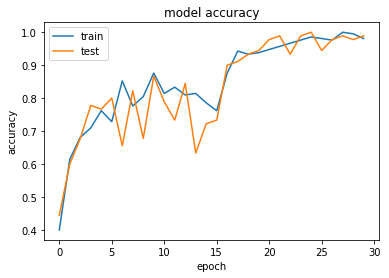

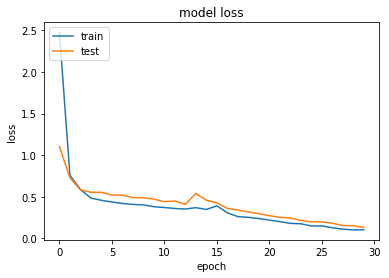

In [462]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [463]:
X_test = generate_a_disk()
model.predict(X_test.reshape(-1,1,5184))

array([[[0., 1., 0.]]], dtype=float32)

# Visualization of the solution

In [464]:
def visualize_column(model):
    weights = model.get_weights()[0]
    weights = weights.reshape(IMAGE_SIZE, IMAGE_SIZE, weights.shape[1])
    _, [ax0, ax1, ax2] = plt.subplots(1, 3)
    ax0.imshow(weights[:,:,0], cmap='gray')
    ax1.imshow(weights[:,:,1], cmap='gray')
    ax2.imshow(weights[:,:,2], cmap='gray')

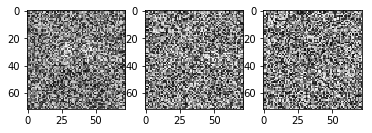

In [467]:
visualize_column(model)


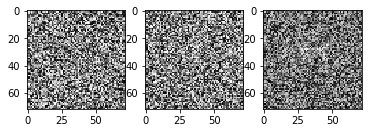

In [468]:
visualize_column(adam_model)

# A more difficult classification problem

In [23]:
[X, y] = generate_dataset_classification(10000, 20, True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train = X_train.reshape(-1,72,72,1)
test = X_test.reshape(-1,72,72,1)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


### RMSProp Optimizer

In [30]:

# dimensions of our images.
img_width, img_height = 72, 72
#275, 3300

#train_data_dir = './Data/Parabolic/trainGeneratedHour3'
#validation_data_dir = './Data/Parabolic/validationGeneratedHour3'
nb_train_samples = 667
nb_validation_samples = 333
epochs = 30
batch_size = 16
nb_channels = 1
input_shape = (img_width, img_height,nb_channels)

model = Sequential()
model.add(Conv2D(32, (4, 4), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Flatten())
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(3))
model.add(Activation('sigmoid'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsProp',
              metrics=['accuracy'])


In [31]:
history = model.fit(x=train, y=y_train, batch_size=batch_size,validation_split=0.33, epochs=epochs)
model.evaluate(x=test, y = y_test, batch_size = batch_size)

Train on 5359 samples, validate on 2641 samples
Epoch 1/35
5359/5359 [==============================] - 5s 863us/step - loss: 0.7592 - acc: 0.6787 - val_loss: 0.4437 - val_acc: 0.8728
Epoch 2/35
5359/5359 [==============================] - 4s 704us/step - loss: 0.3654 - acc: 0.8735 - val_loss: 0.2623 - val_acc: 0.9099
Epoch 3/35
5359/5359 [==============================] - 4s 719us/step - loss: 0.2290 - acc: 0.9224 - val_loss: 0.1922 - val_acc: 0.9258
Epoch 4/35
5359/5359 [==============================] - 4s 724us/step - loss: 0.1703 - acc: 0.9416 - val_loss: 0.1450 - val_acc: 0.9428
Epoch 5/35
5359/5359 [==============================] - 4s 728us/step - loss: 0.1363 - acc: 0.9569 - val_loss: 0.1486 - val_acc: 0.9443
Epoch 6/35
5359/5359 [==============================] - 4s 715us/step - loss: 0.1233 - acc: 0.9561 - val_loss: 0.1243 - val_acc: 0.9557
Epoch 7/35
5359/5359 [==============================] - 4s 729us/step - loss: 0.0982 - acc: 0.9677 - val_loss: 0.2563 - val_acc: 0.9193


[0.12280375196631212, 0.9725]

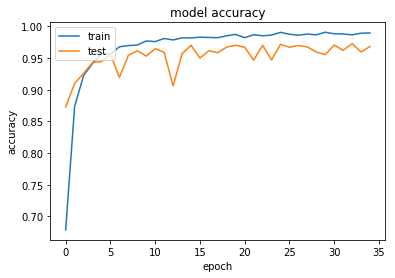

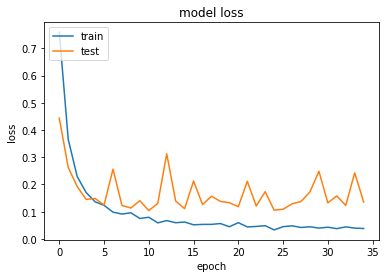

In [32]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Adam Optimizer

In [16]:

# dimensions of our images.
img_width, img_height = 72, 72
nb_train_samples = 667
nb_validation_samples = 333
epochs = 30
batch_size = 16
nb_channels = 1
input_shape = (img_width, img_height,nb_channels)

model = Sequential()
model.add(Conv2D(32, (4, 4), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Flatten())
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.35))
model.add(Dense(3))
model.add(Activation('sigmoid'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [17]:
history = model.fit(x=train, y=y_train, batch_size=batch_size,validation_split=0.33, epochs=epochs, verbose=1000)
model.evaluate(x=test, y = y_test, batch_size = batch_size, verbose =1000)

Train on 5359 samples, validate on 2641 samples
Epoch 1/60
Epoch 2/60
Epoch 3/60
Epoch 4/60
Epoch 5/60
Epoch 6/60
Epoch 7/60
Epoch 8/60
Epoch 9/60
Epoch 10/60
Epoch 11/60
Epoch 12/60
Epoch 13/60
Epoch 14/60
Epoch 15/60
Epoch 16/60
Epoch 17/60
Epoch 18/60
Epoch 19/60
Epoch 20/60
Epoch 21/60
Epoch 22/60
Epoch 23/60
Epoch 24/60
Epoch 25/60
Epoch 26/60
Epoch 27/60
Epoch 28/60
Epoch 29/60
Epoch 30/60
Epoch 31/60
Epoch 32/60
Epoch 33/60
Epoch 34/60
Epoch 35/60
Epoch 36/60
Epoch 37/60
Epoch 38/60
Epoch 39/60
Epoch 40/60
Epoch 41/60
Epoch 42/60
Epoch 43/60
Epoch 44/60
Epoch 45/60
Epoch 46/60
Epoch 47/60
Epoch 48/60
Epoch 49/60
Epoch 50/60
Epoch 51/60
Epoch 52/60
Epoch 53/60
Epoch 54/60
Epoch 55/60
Epoch 56/60
Epoch 57/60
Epoch 58/60
Epoch 59/60
Epoch 60/60


[0.21658433027911814, 0.9615]

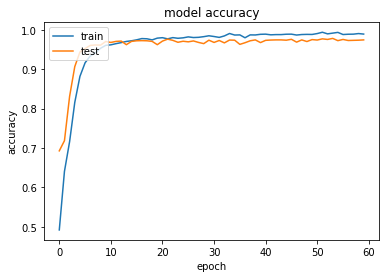

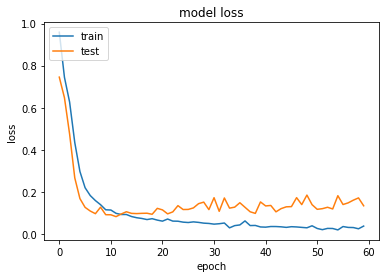

In [18]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In this question I have been using, at the end, a lot of data in order to see if it could improve the performance of the model. The final loss is evaluated on the graphs.

# A regression problem


In [214]:
[X, y_old] = generate_dataset_regression(9000, 20)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500


### Normalization step

The problem here is that the order of the vertices in y follows a pattern that is not simple. The first vertice seems to be the minimum in x axis then the following are selected clockwise. 
To prove that having a simple target helped the model concentrating on the research of one set of patterns, I tried to predict the gravitycenter of the triangle first. 
After this test I understood that I had to create a much simpler order in the coordinates of the triangle's vertices. So I ordered them along x axis. 


In [292]:
def modifY(former_y):
    y = []
    for sub_y in former_y:
        ordered_sub_y = []
        x_values = sub_y[[0,2,4]]
        indexes = sorted(range(3), key=lambda k: x_values[k])
        for indice in indexes:
            ordered_sub_y.append(sub_y[2*indice])
            ordered_sub_y.append(sub_y[2*indice + 1])
        y.append(ordered_sub_y)
    return np.array(y)
y = modifY(y)   

In [ ]:
x_G = y[:,[0,2,4]].sum(axis = 1)/3
y_G = y[:,[1,3,5]].sum(axis = 1)/3
X_G = [[x] for x in x_G]
Y_G = [[y] for y in y_G]
#y = np.concatenate((y,np.concatenate((X_G,Y_G),axis=1)),axis =1)


In [216]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train = X_train.reshape(-1,72,72,1)
test = X_test.reshape(-1,72,72,1)

In [252]:

# dimensions of our images.
img_width, img_height = 72, 72
epochs = 50
batch_size = 16
nb_channels = 1
input_shape = (img_width, img_height,nb_channels)

model = Sequential()
model.add(Conv2D(256, (6, 6), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

#model.add(Dropout(0.15))

model.add(Conv2D(128, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

#model.add(Dropout(0.15))

model.add(Conv2D(128, (4, 4)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(6, kernel_initializer='normal'))

model.compile(loss='mean_squared_error',#logcosh
              optimizer='adam',
              metrics=['mse'])


In [253]:
history = model.fit(x=train, y=y_train, batch_size=batch_size,validation_split=0.33, epochs=epochs)
#model.evaluate(x=test, y = y_test[:,0:2], batch_size = batch_size, verbose =1000)

Train on 4823 samples, validate on 2377 samples
Epoch 1/50
4823/4823 [==============================] - 13s 3ms/step - loss: 0.0398 - mean_squared_error: 0.0398 - val_loss: 0.0145 - val_mean_squared_error: 0.0145
Epoch 2/50
4823/4823 [==============================] - 11s 2ms/step - loss: 0.0143 - mean_squared_error: 0.0143 - val_loss: 0.0091 - val_mean_squared_error: 0.0091
Epoch 3/50
4823/4823 [==============================] - 11s 2ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 4/50
4823/4823 [==============================] - 11s 2ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 5/50
4823/4823 [==============================] - 11s 2ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 6/50
4823/4823 [==============================] - 11s 2ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.

4823/4823 [==============================] - 11s 2ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0028 - val_mean_squared_error: 0.0028


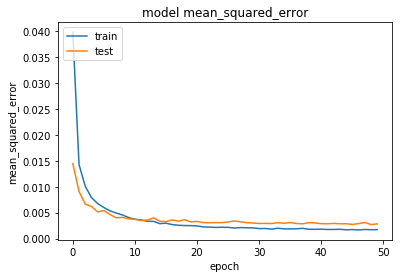

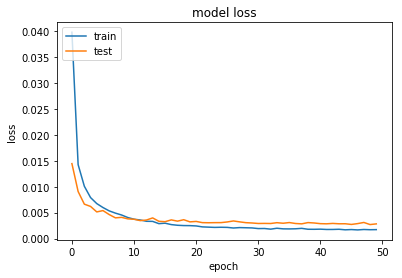

In [254]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mean_squared_error')
plt.ylabel('mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

With this model we reach quite a successfull mean-squared-error in a few epochs, only around 20

In [293]:
[X_test, Y_test] = generate_test_set_regression()
Y_test = modifY(Y_test) 
X_test = X_test.reshape(-1,72,72,1)
model.evaluate(X_test,Y_test)


0
300/300 [==============================] - 1s 3ms/step


[0.0042466631593803565, 0.0042466631593803565]

Finally I chose the loss and the metric to be both MSE, so the results are redundant. And with this model a quite better performance is achieved, without overfitting thanks to dropout layer's effects. 
But let's take a look at the border predicted by the model. 

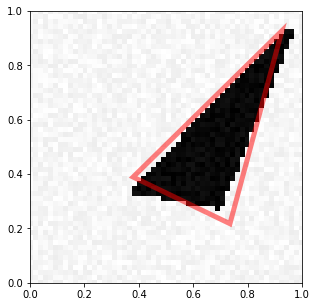

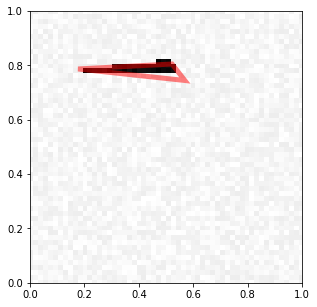

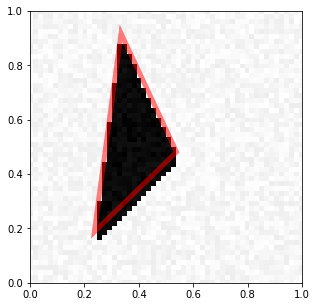

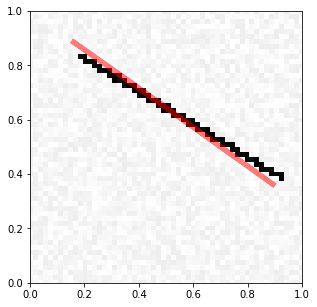

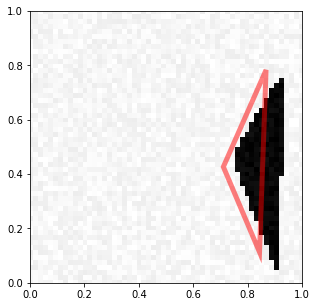

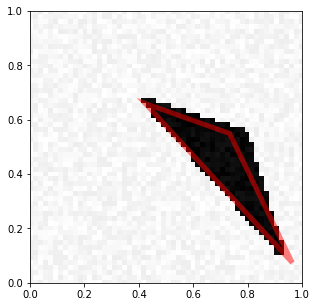

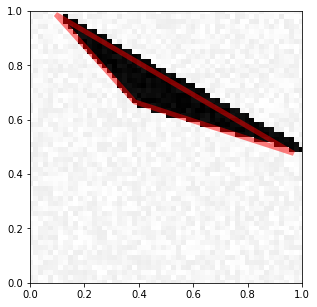

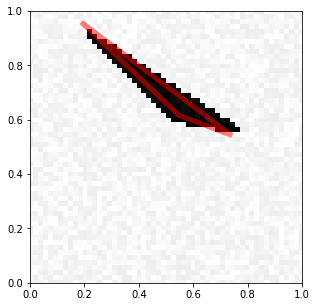

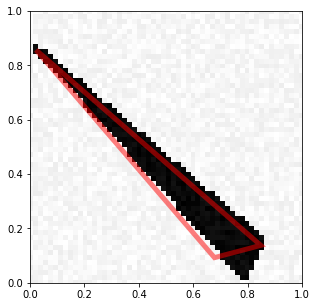

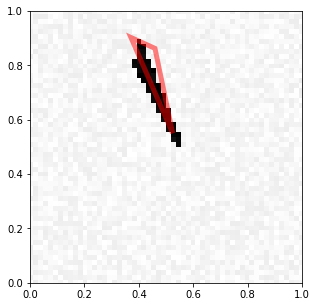

In [282]:
values = range(10)
for value in values:
    visualize_prediction(X_test[value],model.predict(X_test[value].reshape(-1,72,72,1)))
    

# Image Denoising

In order to address this question, I decided to use a known architecture : The Unet architecture.

In [344]:
def unet(pretrained_weights = None,input_size = (72,72,1)):
    inputs = Input(input_size)

    conv2 = Conv2D(16, 4, activation = 'relu', padding = 'same')(inputs)

    drop3 = Dropout(0.2)(conv2)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop3)
        
    up4 = Conv2D(16, 4, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(pool4))
    
    merge4 = concatenate([drop3,up4], axis = 3)
    
    conv9 = Conv2D(16, 4, activation = 'relu', padding = 'same')(merge4)

    conv10 = Conv2D(1, 4, activation = 'sigmoid', padding = 'same')(conv9)
    
    model = Model(input = inputs, output = conv10)
    
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    model.summary()
    
    return model

In [318]:
"""
Let's modify the functions to fit the """
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return [generate_a_drawing(figsize, U, V, noise),generate_a_drawing(figsize, U, V, 0)]


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return [generate_a_drawing(figsize, U, V, noise), generate_a_drawing(figsize, U, V, 0)]

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [generate_a_drawing(figsize, U, V, noise), generate_a_drawing(figsize, U, V, 0) ]

def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    
    X = np.zeros([nb_samples,IMAGE_SIZE**2])
    Y = np.zeros([nb_samples, IMAGE_SIZE**2])
    #print('Creating data:')
    for i in range(nb_samples):
        if i % 1000 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            [X[i],Y[i]] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            [X[i],Y[i]] = generate_a_disk(noise, free_location)
        else:
            [X[i],Y[i]] = generate_a_triangle(noise, free_location)
            
    X = (X + noise) / (255 + 2 * noise)
    Y = Y / 255
    return [X, Y]

In [338]:
[X, Y] = generate_dataset_classification(2000,170, True)

0
1000


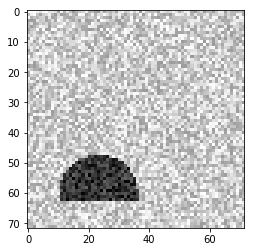

In [340]:
numero_random = np.random.randint(0,2000)
plt.imshow(X[numero_random].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


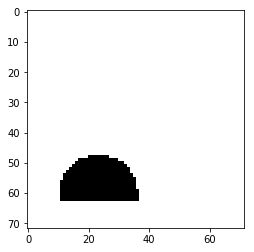

In [341]:
plt.imshow(Y[numero_random].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


In [342]:
X_train = X.reshape(-1,72,72,1)
Y_train = Y.reshape(-1,72,72,1)

In [355]:
model = unet()
history = model.fit(X_train, Y_train,epochs=30, validation_split=0.33,  batch_size=16)


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 72, 72, 1)    0                                            
__________________________________________________________________________________________________
conv2d_135 (Conv2D)             (None, 72, 72, 16)   272         input_5[0][0]                    
__________________________________________________________________________________________________
dropout_44 (Dropout)            (None, 72, 72, 16)   0           conv2d_135[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_122 (MaxPooling2D (None, 36, 36, 16)   0           dropout_44[0][0]                 
__________________________________________________________________________________________________
up_samplin

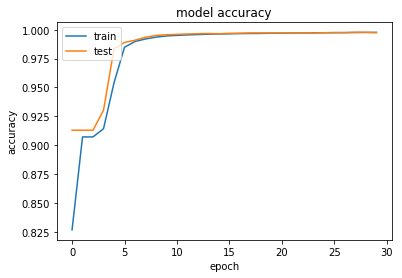

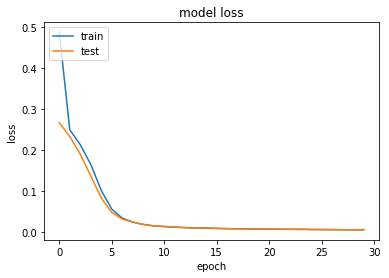

In [359]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [360]:
[X_test, Y_test] = generate_dataset_classification(200, 20, True)
X_test = X_test.reshape(200,72,72,1)
Y_test = Y_test.reshape(200,72,72,1)

0


In [367]:
model.evaluate(X_test,Y_test)

200/200 [==============================] - 1s 3ms/step


[0.01690566346049309, 0.9945032858848571]

Pour une première tentative, le modèle unet performe correctement.

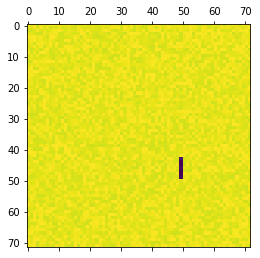

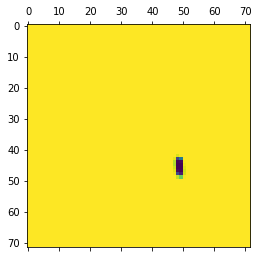

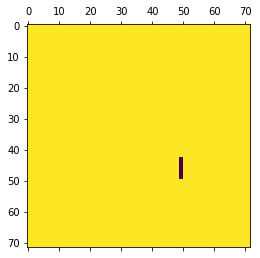

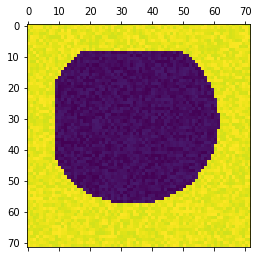

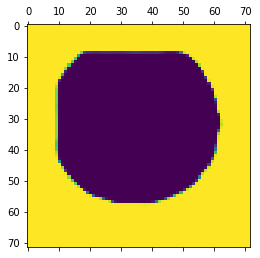

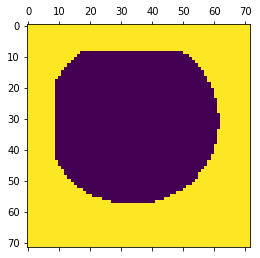

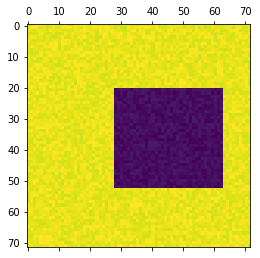

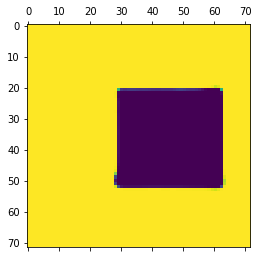

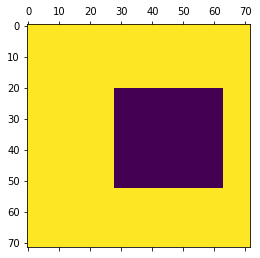

In [366]:
for _ in range(3):
    random_number= np.random.randint(0,200)
    X = X_test[random_number].reshape((72,72))
    Y = Y_test[random_number].reshape((72,72))
    Y_pred = model.predict(X_test[random_number].reshape(1,72,72,1)).reshape(72,72)
    plt.matshow(X)
    plt.matshow(Y_pred)
    plt.matshow(Y)